# Self-Driving Car Engineer Nanodegree


## Project: **Vehicle Detection** 

## Utility fuctions

In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
from skimage.feature import hog

from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split  #scikit-learn >= 0.18
#from sklearn.cross_validation import train_test_split #scikit-learn <= 0.17

import time

%matplotlib inline

In [2]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                                  visualise=True, feature_vector=False)
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                       visualise=False, feature_vector=feature_vec)
        return features

In [3]:
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    features = cv2.resize(img, size).ravel() 
    return features

In [4]:
# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

In [5]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        img = cv2.imread(file)
        img_flip = cv2.flip(img,1)
        images = []
        images.append(img)
        images.append(img_flip)
        for image in images:
            
            file_features = []    
            
            # apply color conversion if other than 'RGB'
            if color_space != 'RGB':
                if color_space == 'HSV':
                    feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
                elif color_space == 'LUV':
                    feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
                elif color_space == 'HLS':
                    feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
                elif color_space == 'YUV':
                    feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
                elif color_space == 'YCrCb':
                    feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
            else: feature_image = np.copy(image)      

            #=== 1. bin_spatial feature ===
            if spatial_feat == True:
                spatial_features = bin_spatial(feature_image, size=spatial_size)
                file_features.append(spatial_features)

            #=== 2. color_hist feature ===
            if hist_feat == True:
                # Apply color_hist()
                hist_features = color_hist(feature_image, nbins=hist_bins)
                file_features.append(hist_features)

            #=== 3. hog_feat feature ===
            if hog_feat == True:
            # Call get_hog_features() with vis=False, feature_vec=True
                if hog_channel == 'ALL':
                    hog_features = []
                    for channel in range(feature_image.shape[2]):
                        hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                            orient, pix_per_cell, cell_per_block, 
                                            vis=False, feature_vec=True))
                    hog_features = np.ravel(hog_features)        
                else:
                    feature_image = cv2.cvtColor(feature_image, cv2.COLOR_LUV2RGB)
                    feature_image = cv2.cvtColor(feature_image, cv2.COLOR_RGB2GRAY)
                    hog_features = get_hog_features(feature_image[:,:], orient, 
                                pix_per_cell, cell_per_block, vis=False, feature_vec=True)
                    
                # Append the new feature vector to the features list
                file_features.append(hog_features)

            #=== 4. append this image file feature to features ===
            features.append(np.concatenate(file_features))
        
    # Return list of feature vectors
    return features

In [6]:
def draw_boxes(img,bboxes,color=(0,0,255),thick=6):
    imcopy = np.copy(img)
    for bbox in bboxes:
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    return imcopy

## Load data

In [7]:
car_image_files = glob.glob('vehicles/**/*.png', recursive = True)
notcar_image_files = glob.glob('non-vehicles/**/*.png', recursive = True)
cars = []
notcars = []

for image_file in car_image_files:
    cars.append (image_file)
for image_file in notcar_image_files:
    notcars.append (image_file)

len_cars = len(cars)
len_notcars = len(notcars)
print('Car samples size :', len_cars)
print('Not Car smaples size :', len_notcars)

Car samples size : 8792
Not Car smaples size : 8968


In [8]:
def show_image (img):
    plt.figure()
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()

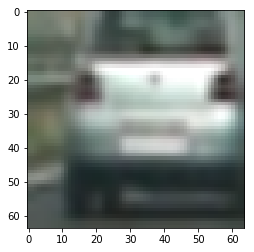

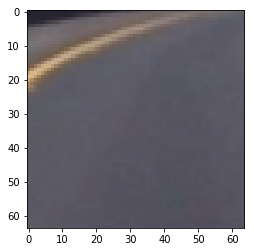

In [9]:
show_image (cv2.imread(cars[100]))
show_image (cv2.imread(notcars[100]))

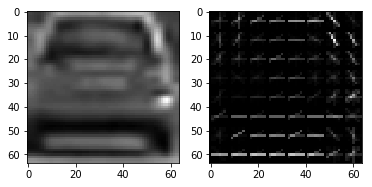

In [10]:
ind = np.random.randint(0,len_cars-1)
ind = 10

image = cv2.imread(cars[ind])
image = cv2.cvtColor(image, cv2.COLOR_BGR2LUV)
#image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#gray = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
imageV = image[:,:,0]

orient = 8
pix_per_cell = 8
cell_per_block = 2

features, hog_image = get_hog_features (imageV, orient, pix_per_cell, cell_per_block, vis=True, feature_vec=False)

fig = plt.figure()
plt.subplot(121)
plt.imshow(imageV, cmap = 'gray')
plt.subplot(122)
plt.imshow(hog_image, cmap = 'gray')

## Train classifier

In [11]:
color_space = 'LUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 8    # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 0 # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off


car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

print("Car feature samples : ", len(car_features))
print("Notcar feature samples : ", len(notcar_features))

X = np.vstack((car_features, notcar_features)).astype(np.float64)    

X_scaler = StandardScaler().fit(X)
scaled_X = X_scaler.transform(X)

y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
#rand_state = np.random.randint(0, 100)
rand_state = 10
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell, 'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

svc = LinearSVC()
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

Car feature samples :  17584
Notcar feature samples :  17936
Using: 8 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 2432
16.36 Seconds to train SVC...
Test Accuracy of SVC =  0.9885


## Slide window

In [12]:
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

## Test sliding window

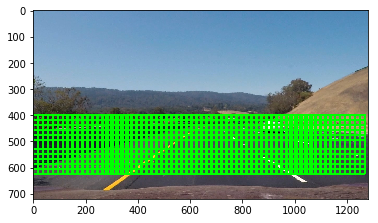

In [13]:
img = mpimg.imread('test_images/test3.jpg')
windows = slide_window(img, x_start_stop=[None, None], y_start_stop=[400, 640], 
                    xy_window=(128, 128), xy_overlap=(0.85, 0.85))
result = draw_boxes(img, windows, color=(0, 255, 0), thick=6)                        
show_image(cv2.cvtColor(result,cv2.COLOR_RGB2BGR))

In [14]:
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

In [15]:
# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

## Test search windows function

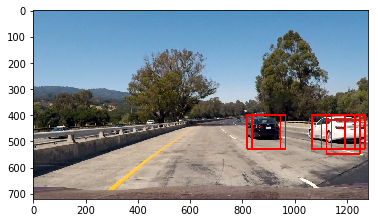

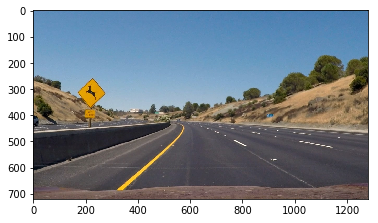

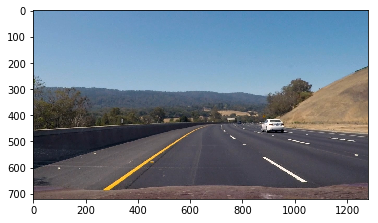

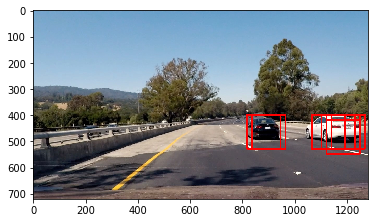

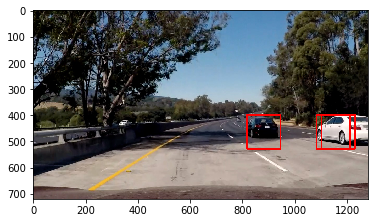

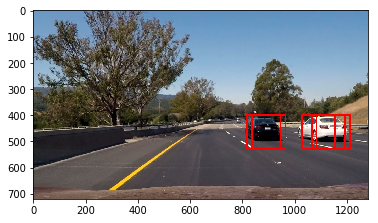

7.89 Seconds to process test images


In [16]:
t=time.time() # Start time
for image_p in glob.glob('test_images/test*.jpg'):
    image = cv2.imread(image_p)
    draw_image = np.copy(image)
    windows = slide_window(image, x_start_stop=[None, None], y_start_stop=[400, 640], 
                    xy_window=(128, 128), xy_overlap=(0.85, 0.85))
    hot_windows = []
    hot_windows += (search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat))                       
    window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    
    show_image(window_img)
print(round(time.time()-t, 2), 'Seconds to process test images')

## Find cars boxes

In [17]:
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

In [18]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars_boxes(img, ystart, ystop, xstart, xstop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    bboxes = []
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,xstart:xstop,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2LUV')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_features = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale) + xstart
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                
                bboxes.append( ( (int(xbox_left), int(ytop_draw+ystart)),(int(xbox_left+win_draw), int(ytop_draw+win_draw+ystart)) ) )
                
    return bboxes

## Test find cars boxes module

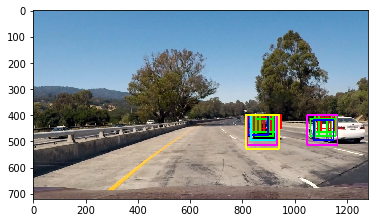

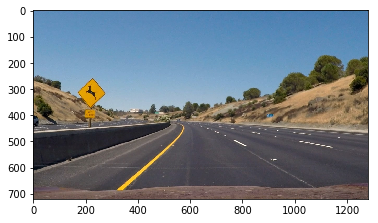

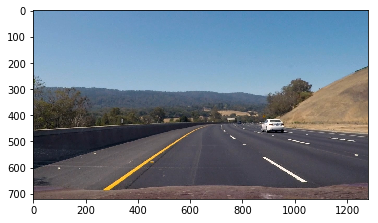

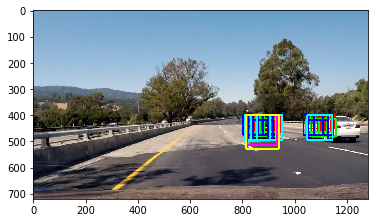

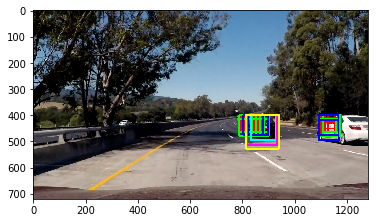

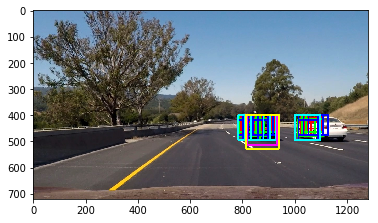

In [19]:
for image_p in glob.glob('test_images/test*.jpg'):
    img = cv2.imread(image_p)

    cars_boxes1 = find_cars_boxes(img, 400, 650, 500, 1200, 0.8, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    cars_boxes2 = find_cars_boxes(img, 400, 650, 500, 1200, 1.0, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)    
    cars_boxes3 = find_cars_boxes(img, 400, 650, 400, 1200, 1.2, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)    
    cars_boxes4 = find_cars_boxes(img, 400, 650, 400, 1200, 1.5, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    cars_boxes5 = find_cars_boxes(img, 400, 650, 300, 1200, 1.8, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)    
    cars_boxes6 = find_cars_boxes(img, 400, 650, 300, 1200, 2.0, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)        
    
    
    img = draw_boxes(img,cars_boxes1,color=(0,0,255))
    img = draw_boxes(img,cars_boxes2,color=(0,255,0))    
    img = draw_boxes(img,cars_boxes3,color=(255,0,0))    
    img = draw_boxes(img,cars_boxes4,color=(255,255,0))   
    img = draw_boxes(img,cars_boxes5,color=(255,0,255))       
    img = draw_boxes(img,cars_boxes6,color=(0,255,255))           
    
    show_image(img)

In [20]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    return heatmap# Iterate through list of bboxes
   
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    bboxes = []
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((int(np.min(nonzerox)), int(np.min(nonzeroy))), (int(np.max(nonzerox)), int(np.max(nonzeroy))))       
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
        bboxes.append( (bbox[0], bbox[1]) )
        
    return bboxes

In [21]:
from scipy.ndimage.measurements import label

def vehicle_detect (img, heatmap_return = False):
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    cars_boxes = []
    cars_boxes1 = find_cars_boxes(img, 400, 650, 500, 1200, 0.8, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    cars_boxes2 = find_cars_boxes(img, 400, 650, 500, 1200, 1.0, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)    
    cars_boxes3 = find_cars_boxes(img, 400, 650, 400, 1200, 1.2, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)    
    cars_boxes4 = find_cars_boxes(img, 400, 650, 400, 1200, 1.5, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    cars_boxes5 = find_cars_boxes(img, 400, 650, 300, 1200, 1.8, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)    
    cars_boxes6 = find_cars_boxes(img, 400, 650, 300, 1200, 2.0, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)        
    
    cars_boxes+=cars_boxes1
    cars_boxes+=cars_boxes2
    cars_boxes+=cars_boxes3
    cars_boxes+=cars_boxes4    
    cars_boxes+=cars_boxes5
    cars_boxes+=cars_boxes6 
    
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    heat = add_heat(heat,cars_boxes)
    heat = apply_threshold(heat,5)
    heatmap = np.clip(heat, 0, 255)
    labels = label(heatmap)
    cars_boxes = draw_labeled_bboxes(np.copy(img), labels)
    result = draw_boxes(img,cars_boxes)
    result = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)
    if heatmap_return == True:
        return result, heatmap
    elif heatmap_return == False:
        return result

## Test vehicle detect module

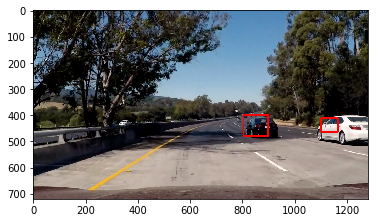

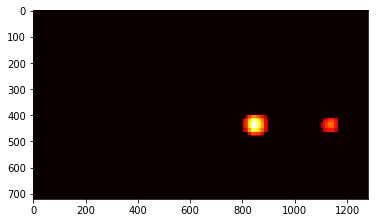

In [22]:
img = mpimg.imread('test_images/test5.jpg')
    
result, heatmap = vehicle_detect(img, heatmap_return=True)
show_image(cv2.cvtColor(result,cv2.COLOR_RGB2BGR))

fig = plt.figure()
plt.imshow(heatmap, cmap='hot')

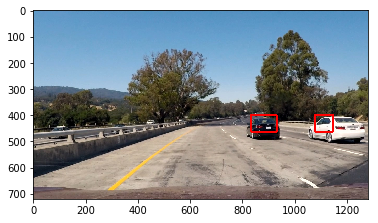

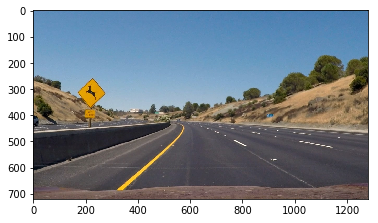

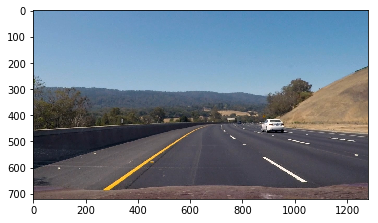

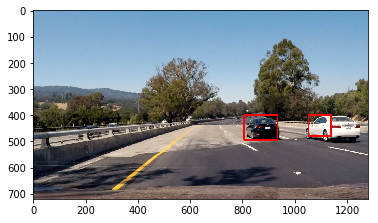

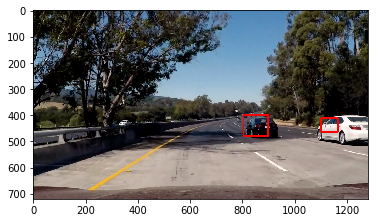

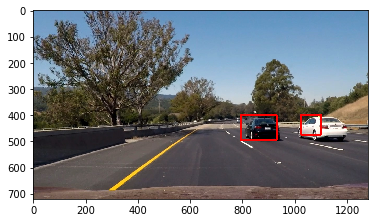

In [23]:
for image_p in glob.glob('test_images/test*.jpg'):
    img = mpimg.imread(image_p)
    result = vehicle_detect(img)
    show_image(cv2.cvtColor(result,cv2.COLOR_RGB2BGR))

## Generate processed video

In [24]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

write_output = 'project_video_vehicle_detect_out.mp4'
clip1 = VideoFileClip("project_video.mp4")
write_clip = clip1.fl_image(vehicle_detect) #NOTE: this function expects color images!!
%time write_clip.write_videofile(write_output, audio=False)

[MoviePy] >>>> Building video project_video_vehicle_detect_out.mp4
[MoviePy] Writing video project_video_vehicle_detect_out.mp4


100%|█████████▉| 1260/1261 [35:14<00:01,  1.74s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_vehicle_detect_out.mp4 

CPU times: user 33min 38s, sys: 1min 49s, total: 35min 28s
Wall time: 35min 16s
